### Import Data
Predict the airline on-time performance based the data from Bureau of Transportation Statics
http://transtats.bts.gov/Tables.asp?DB_ID=120&DB_Name=Airline%20On-Time%20Performance%20Data&DB_Short_Name=On-Time

In [1]:
import glob
import os

!ls ./bts_data


300123874_T_ONTIME-1.zip  300123874_T_ONTIME-7.zip  300123874_T_ONTIME4.csv
300123874_T_ONTIME-10.zip 300123874_T_ONTIME-8.zip  300123874_T_ONTIME5.csv
300123874_T_ONTIME-2.zip  300123874_T_ONTIME-9.zip  300123874_T_ONTIME6.csv
300123874_T_ONTIME-3.zip  300123874_T_ONTIME1.csv   300123874_T_ONTIME7.csv
300123874_T_ONTIME-4.zip  300123874_T_ONTIME10.csv  300123874_T_ONTIME8.csv
300123874_T_ONTIME-5.zip  300123874_T_ONTIME2.csv   300123874_T_ONTIME9.csv
300123874_T_ONTIME-6.zip  300123874_T_ONTIME3.csv


In [2]:
%matplotlib inline 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Asemble 2016 on time flight data by combining monthly BTS reports

all_data = pd.DataFrame()
for f in glob.glob("./bts_data/*.csv"):
    df = pd.read_csv(f)
    all_data = all_data.append(df,ignore_index=True)

#data_file = './86361664_T_ONTIME.csv'
#full_data = pd.read_csv(data_file)
data = all_data[['MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','FL_NUM', 'TAIL_NUM','ORIGIN','DEST','CRS_DEP_TIME','DISTANCE','ARR_DELAY_NEW']]
data = data.dropna(axis=0) 

### Explore Data

Summary of ARRIVAL_DELAY statistics: 


count    4.611195e+06
mean     1.121138e+01
std      3.680890e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+00
max      2.142000e+03
Name: ARR_DELAY_NEW, dtype: float64

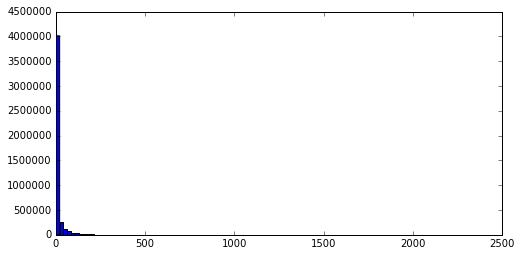

In [3]:
y = data['ARR_DELAY_NEW']
plt.figure(figsize=(8,4))
plt.hist(y,bins =100)
print('Summary of ARRIVAL_DELAY statistics: ')
display(y.describe())


### Remove Outliners

Percent of Outliers: 1.1 %
Summary of ARRIVAL_DELAY statistics: 


count    4.559912e+06
mean     8.451822e+00
std      2.143289e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+00
max      1.580000e+02
Name: ARR_DELAY_NEW, dtype: float64

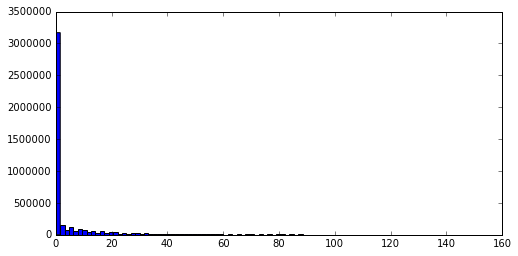

In [4]:
# Detect outliers
y_mean = y.mean()
y_std = y.std()
outliers = y[y-y_mean >4*y_std]
print 'Percent of Outliers: %.1f' % (len(outliers)*100./len(y)),'%'


c_data = data.copy()
c_data = data.drop(outliers.index)

y = c_data['ARR_DELAY_NEW']
plt.figure(figsize=(8,4))
plt.hist(y,bins =100)
print('Summary of ARRIVAL_DELAY statistics: ')
display(y.describe())



In [5]:
# Show statistics for each category

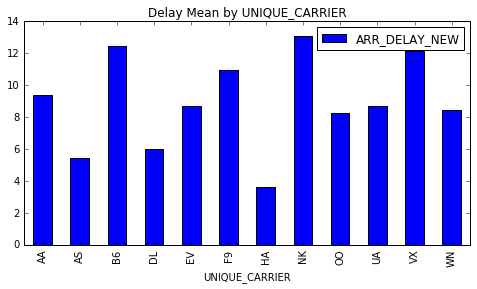

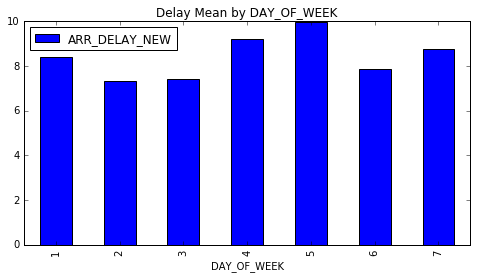

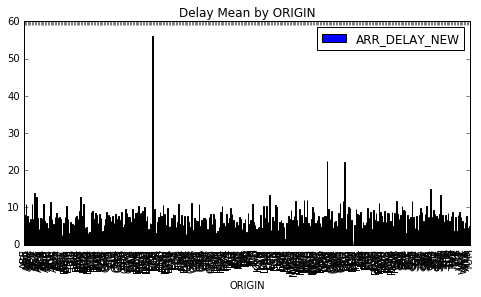

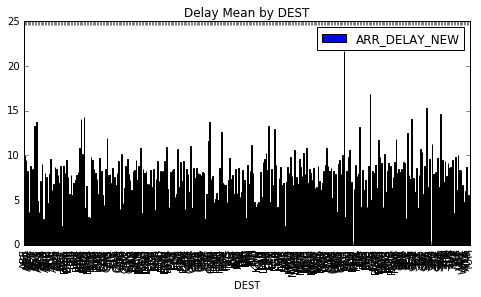

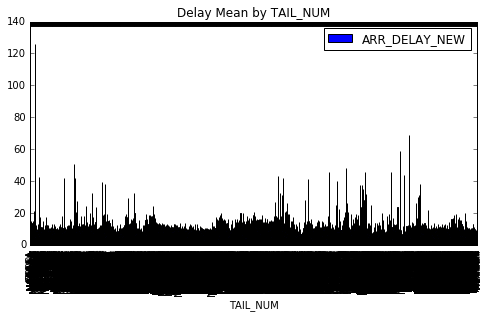

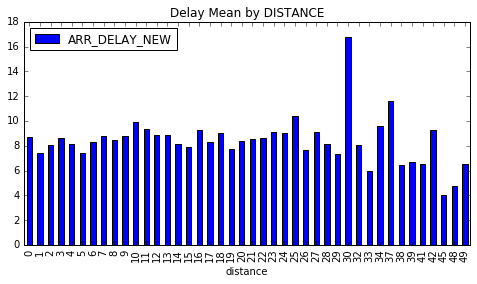

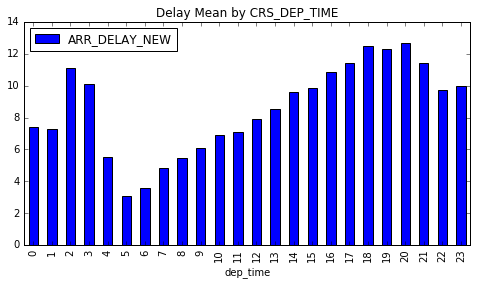

In [6]:
delay_carrier = c_data[['ARR_DELAY_NEW','UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').mean()
delay_carrier.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by UNIQUE_CARRIER')

delay_day = c_data[['ARR_DELAY_NEW','DAY_OF_WEEK']].groupby('DAY_OF_WEEK').mean()
delay_day.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by DAY_OF_WEEK')

delay_origin = c_data[['ARR_DELAY_NEW','ORIGIN']].groupby('ORIGIN').mean()
delay_origin.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by ORIGIN')

delay_dest = c_data[['ARR_DELAY_NEW','DEST']].groupby('DEST').mean()
delay_dest.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by DEST')

delay_tail = c_data[['ARR_DELAY_NEW','TAIL_NUM']].groupby('TAIL_NUM').mean()
delay_tail.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by TAIL_NUM')

# Bucketze the distantce by 100.
c_data.loc[:,('distance')] = [int(i//100) for i in c_data['DISTANCE']]  

delay_distance = c_data[['ARR_DELAY_NEW','distance']].groupby('distance').mean()
delay_distance.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by DISTANCE')

# Bucketize time by hours
c_data.loc[:,('dep_time')] = [i//100 for i in c_data['CRS_DEP_TIME']]   

delay_dep_time = c_data[['ARR_DELAY_NEW','dep_time']].groupby('dep_time').mean()
delay_dep_time.plot(kind='bar',figsize =(8,4),title = 'Delay Mean by CRS_DEP_TIME')




### Extract train and test data

### Preprocess the data

In [7]:
r_data = c_data.copy() 

from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
le.fit(r_data['DEST'])
dest_le = le.transform(r_data['DEST'])
print dest_le

le.fit(data['ORIGIN'])
origin_le = le.transform(r_data['ORIGIN'])
print origin_le

le.fit(data['UNIQUE_CARRIER'])
carrier_le = le.transform(r_data['UNIQUE_CARRIER'])
print carrier_le

r_data.loc[:,('dest_le')] = dest_le
r_data.loc[:,('origin_le')] = origin_le
r_data.loc[:,('carrier_le')] = carrier_le
#data.loc[:,('flight_le')] = flight_le
#data.loc[:,('tail_le')] = tail_le
#print r_data.head(5)
cols = ['DAY_OF_WEEK','carrier_le','dep_time','origin_le','distance']

X = r_data[cols]
y = r_data['ARR_DELAY_NEW']
print X.head(5)
print y.head(5)


[ 85  85  85 ..., 258 258 258]
[ 79  79  79 ..., 296 296 296]
[ 0  0  0 ..., 11 11 11]
   DAY_OF_WEEK  carrier_le  dep_time  origin_le  distance
0            3           0        11         79         9
1            4           0        11         79         9
2            5           0        11         79         9
3            6           0        11         79         9
4            7           0        11         79         9
0      0.0
1      0.0
2      7.0
3      0.0
4    113.0
Name: ARR_DELAY_NEW, dtype: float64


In [8]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features='all')
X_ohe = ohe.fit_transform(X)



In [9]:
XX = X_ohe.toarray()
yy = y.values

In [ ]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(XX,yy, test_size =0.2,random_state =0)

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs = -1)
lr.fit(X_train,y_train)
r = lr.score(X_test,y_test)